In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn import metrics
%matplotlib inline
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,auc

# Preparing Dataset

In [2]:
data = pd.read_csv('customers_data.csv')
data=data.drop(['Unnamed: 0'],axis=1)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 6 columns):
purch_amt                120000 non-null float64
gender                   120000 non-null object
card_on_file             120000 non-null object
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty                  120000 non-null bool
dtypes: bool(1), float64(3), object(2)
memory usage: 4.7+ MB


In [4]:
#we're gonna convert the boolean column to an integer column 
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
lab_enc.fit(data['loyalty'])
variable = lab_enc.transform(data['loyalty'])
data['loyalty_int'] = variable

In [5]:
data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty,loyalty_int
0,19.58,male,no,31.0,35.0,False,0
1,65.16,male,yes,23.0,61.0,False,0
2,40.60,female,no,36.0,49.0,False,0
3,38.01,male,yes,47.0,57.0,False,0
4,22.32,female,yes,5.0,39.0,False,0


In [6]:
data = data.dropna()
data.shape

(120000, 7)

In [7]:
data.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty,loyalty_int
0,19.58,male,no,31.0,35.0,False,0
1,65.16,male,yes,23.0,61.0,False,0
2,40.60,female,no,36.0,49.0,False,0
3,38.01,male,yes,47.0,57.0,False,0
4,22.32,female,yes,5.0,39.0,False,0


# Exploring the Data

In [8]:
data.groupby('loyalty_int').size()

loyalty_int
0    100000
1     20000
dtype: int64

In [9]:
# male = 1, female = 0
# card_on_file: y = 1, n = 0
# loyalty (now named variable): True = 1, False = 0
data = data.drop(['loyalty'],axis=1)
data['card_on_file'] = data['card_on_file'].apply(lambda x: 1 if x=='yes' else 0)
data['gender'] = data['gender'].apply(lambda x: 1 if x=='male' else 0)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120000 entries, 0 to 119999
Data columns (total 6 columns):
purch_amt                120000 non-null float64
gender                   120000 non-null int64
card_on_file             120000 non-null int64
age                      120000 non-null float64
days_since_last_purch    120000 non-null float64
loyalty_int              120000 non-null int64
dtypes: float64(3), int64(3)
memory usage: 6.4 MB


Text(0,0.5,'Frequency')

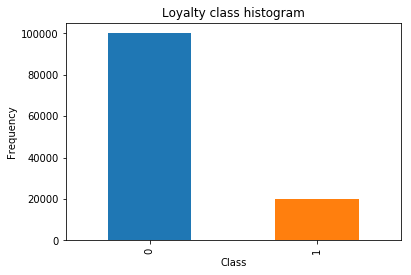

In [11]:
loyalty_classes=pd.value_counts(data['loyalty_int'])
loyalty_classes.plot(kind='bar')
plt.title("Loyalty class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

Here we see a clear class imbalance. Of the 12000 rows in the loyalty (true/false) column, 10000 are non-loyalty program individuals. For a more accurate and convincing classifier, we need to correct this before the train-test split. 

In [12]:
data_dummies = pd.get_dummies(data)
data_dummies.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty_int
0,19.58,1,0,31.0,35.0,0
1,65.16,1,1,23.0,61.0,0
2,40.60,0,0,36.0,49.0,0
3,38.01,1,1,47.0,57.0,0
4,22.32,0,1,5.0,39.0,0


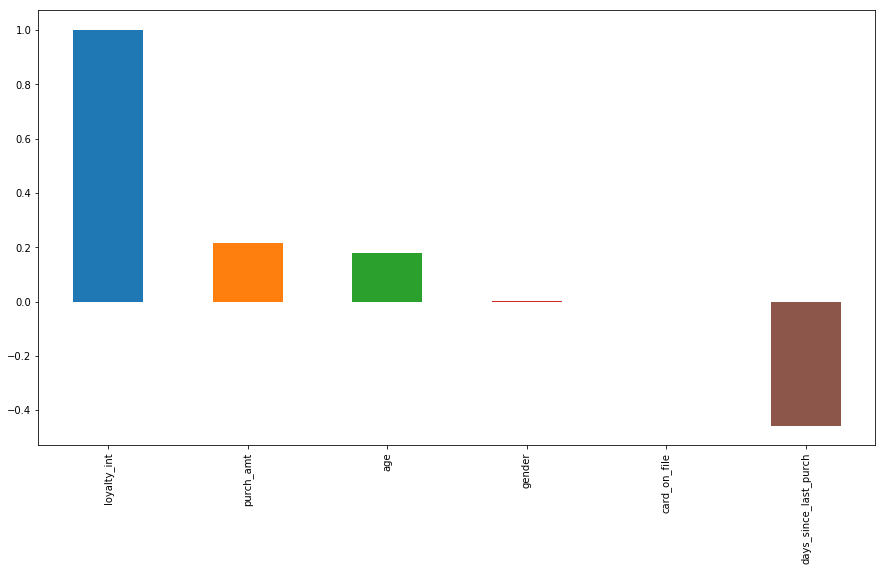

In [13]:
plt.figure(figsize=(15,8))
data_dummies.corr()['loyalty_int'].sort_values(ascending = False).plot(kind='bar')

The graph above shows us the correlation between loyalty and other features. Of the features, purchase amount, age and gender are positively correlated, card_on_file has a correlation of 0, and days since last purchase was negatively correlated. With this in mind, and before we proceed to modeling, we will be addressing the class imbalance problem by undersampling the dataset so we have a 50-50 split between loyalty and non-loyalty individuals. 

In [14]:
data_dummies.corr()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty_int
purch_amt,1.000000,0.000036,-0.002979,0.038749,-0.098926,0.216203
gender,0.000036,1.000000,-0.003238,0.006985,-0.000355,0.002810
card_on_file,-0.002979,-0.003238,1.000000,-0.001759,0.002351,-0.000514
age,0.038749,0.006985,-0.001759,1.000000,-0.084457,0.180061
days_since_last_purch,-0.098926,-0.000355,0.002351,-0.084457,1.000000,-0.457012
loyalty_int,0.216203,0.002810,-0.000514,0.180061,-0.457012,1.000000


In [15]:
X=data.loc[:,data.columns!='loyalty_int']
Y=data.loc[:,data.columns=='loyalty_int']

In [16]:
loyalty=len(data[data.loyalty_int==1])
loyalty_index=np.array(data[data.loyalty_int==1].index)
non_loyalty_index=data[data.loyalty_int==0].index
random_non_loyalty=np.random.choice(non_loyalty_index,loyalty,replace=False)
random_non_loyalty_index=np.array(random_non_loyalty)
under_sample_index=np.concatenate([loyalty_index,random_non_loyalty_index])
under_sampling=data.iloc[under_sample_index,:]
X_undersampled=data.loc[:,under_sampling.columns!='loyalty_int']
Y_undersampled=data.loc[:,under_sampling.columns=='loyalty_int']
print("Non Loyalty (%):",len(under_sampling[under_sampling.loyalty_int==0])/len(under_sampling))
print("Loyalty (%):",len(under_sampling[under_sampling.loyalty_int==1])/len(under_sampling))
print("Total number in data:", len(under_sampling))

Non Loyalty (%): 0.5
Loyalty (%): 0.5
Total number in data: 40000


# Modeling: Random Forest Classifier

Now we're on. We will be using a random forest classifier for this case. Reasons for this are: 
1. This is a classification problem
2. It is easy to observe feature importance
3. Provides us with a classification report which gives us precision, f1 score, and recall. 

We're going to keep the test size to 40%, using our newly undersampled dataset. 

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.4, random_state=0)
X_train_under,X_test_under,Y_train_under,Y_test_under=train_test_split(X_undersampled,Y_undersampled, test_size=0.4,random_state=0)

In [18]:
clf=RandomForestClassifier()
clf.fit(X_train_under,Y_train_under)
important_features=pd.Series(clf.feature_importances_,index=X_train_under.columns).sort_values(ascending=False)
print(important_features)

/Users/samuelkim/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/samuelkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


purch_amt                0.419358
days_since_last_purch    0.360370
age                      0.188700
gender                   0.016303
card_on_file             0.015269
dtype: float64


Here we see that purchase amount, at 0.42, is the most important feature, followed by days_since_last_purch, and age. The relative lack of importance of gender and card_on_file came as a bit of a surprise. We'll visualize this below.  

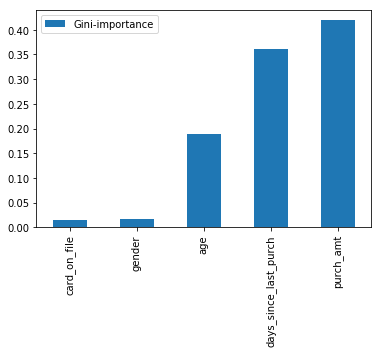

In [19]:
feats={}
for feature,importance in zip(data.columns, clf.feature_importances_):
    feats[feature]=importance
importances=pd.DataFrame.from_dict(feats, orient='index').rename(columns={0:'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar',rot=90)
plt.show()

In [20]:
clf.fit(X_train_under,Y_train_under)
pred=clf.predict(X_test_under)
print(classification_report(Y_test_under,pred))

/Users/samuelkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


              precision    recall  f1-score   support

           0       0.88      0.94      0.91     39978
           1       0.56      0.38      0.45      8022

   micro avg       0.85      0.85      0.85     48000
   macro avg       0.72      0.66      0.68     48000
weighted avg       0.83      0.85      0.83     48000



In [21]:
false_positive,true_positive,thresholds=roc_curve(Y_test_under,pred)
roc_auc=auc(false_positive,true_positive)
print(roc_auc)

0.6585307876699424


We've run a classification report and a roc score to assess how well the model distinguishes between classes - and it doesn't. The model performs well across the board for non-loyalty customers, but is woefully inadequate for loyalty customers. We'll see if dropping the card_on_file feature would improve overall performance/consistency. 

In [22]:
X_train_under_new, X_test_under_new, Y_train_under_new, Y_test_under_new = train_test_split(X_undersampled[['gender','purch_amt','days_since_last_purch','age']], Y_undersampled, 
                                                    test_size=0.40, random_state=50)

In [23]:
clf_new=DecisionTreeClassifier()
clf_new.fit(X_train_under_new, Y_train_under_new)
pred_new=clf_new.predict(X_test_under_new)
print(classification_report(Y_test_under_new, pred_new))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88     39963
           1       0.42      0.44      0.43      8037

   micro avg       0.81      0.81      0.81     48000
   macro avg       0.66      0.66      0.66     48000
weighted avg       0.81      0.81      0.81     48000



The result - model with card_on_file dropped performs at roughly a similar level - the scores are more consistent across the board - especially for loyalty customers. 

In [35]:
model_rf = RandomForestClassifier(n_estimators=500 , n_jobs = -1, random_state =50, max_leaf_nodes = 10)
model_rf.fit(X_train, Y_train)
prediction_test = model_rf.predict(X_test_under)
print (metrics.accuracy_score(Y_test_under, prediction_test))

/Users/samuelkim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.8578541666666667


The accuracy score notwithstanding, a little more work needs to be done with this model, but it is a good start. I will explaining my thought process in greater detail in my write-up (see attached). 